# Train Contextual Bandits with simple linear, stationary simulation environment

> In this notebook, we'll evaluate the performance of Contextual Bandits in stationary, stochastic environments. These are environments whose statistics (e.g., distribution of rewards) do not change over time

* A linear  environment is an environment where the expected reward for each arm `k` is linearly related to the context features `x`
* Train and evaluate linear and non-linear (neural) Contextual Bandit algorithms
* We'll show that linear-based agents converge faster on such an environment, compared to non-linear agents, becasue the problem is linear (by the reward calculation construction)

### Per-arm environment
In this example we will use the [StationaryStochasticPerArmPyEnvironment](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/stationary_stochastic_per_arm_py_environment.py) environment to simulate offline training data for training a contextual bandit with **per-arm features**


To initialize the per-arm environment, one has to define functions that generate:

* **global and per-arm features**: These functions have no input parameters and generate a single (global or per-arm) feature vector when called.
* **rewards**: This function takes as parameter the concatenation of a global and a per-arm feature vector, and generates a reward. Basically this is the function that the agent will have to "guess". 

It is worth noting here that in the per-arm case the reward function is identical for every arm. This is a fundamental difference from the classic bandit case, where the agent has to estimate reward functions for each arm independently.

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

## imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import time
import functools
import pickle as pkl
from pprint import pprint
from datetime import datetime
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar

# logging
import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
# from tf_agents.agents import TFAgent

from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.bandits.policies import policy_utilities

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

from tf_agents.bandits.replay_buffers import bandit_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
# from tf_agents.google.metrics import export_utils
from tf_agents.metrics import export_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import policy_saver

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.utils import policy_util
from src.data import data_utils, data_config
from src.agents import agent_factory as agent_factory
from src.networks import encoding_network as emb_features

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [10]:
from tensorflow.python.platform import build_info

print(f"cudnn version     : {build_info.build_info['cudnn_version']}")
print(f"cuda version      : {build_info.build_info['cuda_version']}")

print(f"tensorflow        : {tf.__version__}")
print(f"aiplatform SDK    : {aiplatform.__version__}")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cudnn version     : 8
cuda version      : 11.8
tensorflow        : 2.13.0
aiplatform SDK    : 1.71.0
Num GPUs Available:  1


In [11]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [12]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

## Read TF Records (for testing)

In [13]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")

# !gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m


In [11]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [14]:
SPLIT = "val" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/ml-1m-gen-001-of-003.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/ml-1m-gen-002-of-003.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/ml-1m-gen-003-of-003.tfrecord']

In [15]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils._parse_function)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
array([[b'Animation', b"Children's", b'Comedy', b'Musical', b'Romance',
        b'UNK', b'UNK', b'UNK', b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2012'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Little Mermaid, The (1989)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1989])>,
 'target_rating_timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([973200386])>,
 'user_age': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([25])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'F'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2749'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dt

### get vocab

In [16]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

for key in vocab_dict.keys():
    pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl

'movie_id'
'movie_year'
'movie_genre'
'movie_title'
'user_id'
'user_gender_vocab'
'user_age_vocab'
'user_occ_vocab'
'user_zip_vocab'
'min_timestamp'
'max_timestamp'
'timestamp_buckets'


# Global & Per-Arm feature embedding models 

In [17]:
# from src.perarm_features import emb_feature as emb_features # tmp

In [18]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 8
MV_EMBEDDING_SIZE      = 16

NUM_GLOBAL_FEATURES = len(data_utils.USER_FEATURE_NAMES)     # 6
NUM_ARM_FEATURES    = len(data_utils.MOVIE_FEATURE_NAMES)    # 5
EXPECTED_GLOBAL_DIM  = GLOBAL_EMBEDDING_SIZE * NUM_GLOBAL_FEATURES
EXPECTED_PER_ARM_DIM = MV_EMBEDDING_SIZE * NUM_ARM_FEATURES
print(f"EXPECTED_GLOBAL_DIM: {EXPECTED_GLOBAL_DIM}")
print(f"EXPECTED_PER_ARM_DIM: {EXPECTED_PER_ARM_DIM}")

EXPECTED_GLOBAL_LAYERS   = [
    EXPECTED_GLOBAL_DIM, 
    int(EXPECTED_GLOBAL_DIM/2), 
    int(EXPECTED_GLOBAL_DIM/4)
]
EXPECTED_ARM_LAYERS      = [
    EXPECTED_PER_ARM_DIM, 
    int(EXPECTED_PER_ARM_DIM/2), 
    int(EXPECTED_PER_ARM_DIM/4)
]
EXPECTED_FIRST_COMMON_LAYER = EXPECTED_GLOBAL_LAYERS[-1] + EXPECTED_ARM_LAYERS[-1]
EXPECTED_COMMON_LAYERS = [
    int(EXPECTED_FIRST_COMMON_LAYER), 
    int(EXPECTED_FIRST_COMMON_LAYER/2), 
    # int(EXPECTED_FIRST_COMMON_LAYER/4)
]
print(f"EXPECTED_GLOBAL_LAYERS      : {EXPECTED_GLOBAL_LAYERS}")
print(f"EXPECTED_ARM_LAYERS         : {EXPECTED_ARM_LAYERS}")
print(f"EXPECTED_COMMON_LAYERS      : {EXPECTED_COMMON_LAYERS}")

EXPECTED_GLOBAL_DIM: 48
EXPECTED_PER_ARM_DIM: 64
EXPECTED_GLOBAL_LAYERS      : [48, 24, 12]
EXPECTED_ARM_LAYERS         : [64, 32, 16]
EXPECTED_COMMON_LAYERS      : [28, 14]


In [19]:
# test emb models
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

# data

In [20]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

embs

In [21]:
test_globals = embs._get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

test_globals

GLOBAL_DIM: 48


<tf.Tensor: shape=(1, 48), dtype=float32, numpy=
array([[ 0.01696311, -0.0145936 ,  0.00596155, -0.01321973, -0.00529853,
        -0.02393426,  0.01597783, -0.02495819, -0.0427852 , -0.02285435,
         0.02400957,  0.03378829, -0.01428828, -0.0334155 ,  0.0162832 ,
        -0.03096678,  0.01983311, -0.0326262 ,  0.02994836, -0.01440335,
         0.04401727,  0.04682611,  0.04997249,  0.02787719,  0.00258783,
        -0.032015  ,  0.00423127,  0.03940067,  0.0228655 ,  0.03639526,
         0.04292269,  0.00090716, -0.03436611, -0.01798915, -0.02806979,
         0.04122556, -0.04614521,  0.03882346, -0.01341803,  0.02428648,
        -0.00467996, -0.04001611,  0.04019647, -0.03055294, -0.02775998,
         0.01297576,  0.00165112,  0.01484631]], dtype=float32)>

In [22]:
test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

test_arms

PER_ARM_DIM: 64


<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 9.54109430e-03,  1.18401535e-02,  1.69528238e-02,
         2.22566240e-02, -2.58977171e-02, -2.05695760e-02,
        -2.25134976e-02, -4.69982624e-02, -4.73292135e-02,
         6.34007528e-03,  1.84393786e-02,  3.84264253e-02,
         2.11890675e-02,  2.29040422e-02,  5.72783872e-03,
         4.58011292e-02,  3.94451730e-02,  1.33983381e-02,
         4.94979061e-02, -1.48658156e-02, -2.64436956e-02,
        -1.32353902e-02, -3.53207476e-02, -4.86463681e-02,
        -2.24044919e-02, -3.24306637e-03,  4.92508896e-02,
        -1.71313398e-02,  9.27747414e-03, -3.67491245e-02,
         4.67903279e-02,  4.04027738e-02,  1.83082409e-02,
         2.33855978e-01,  2.76777804e-01,  3.28691423e-01,
         2.18618333e-01,  2.41870970e-01, -3.14152151e-01,
        -2.86138840e-02,  2.83826232e-01,  1.43554866e-01,
         3.14425826e-01, -3.30198497e-01,  1.27358317e-01,
        -7.99552575e-02,  9.60634351e-02,  3.03068280e-01,
       

# Sampling and reward functions

The preproccesing layers will ultimately feed the two sampling functions described below. These sampling functions will be used to create [trajectories](https://github.com/tensorflow/agents/blob/master/tf_agents/trajectories/trajectory.py#L36) (i.e., the training examples for our model)

`global_context_sampling_fn`: 
* A function that outputs a random 1d array or list of ints or floats
* This output is the global context. Its shape and type must be consistent across calls.

`arm_context_sampling_fn`: 
* A function that outputs a random 1 array or list of ints or floats (same type as the output of `global_context_sampling_fn`). 
* This output is the per-arm context. Its shape must be consistent across calls.

`reward_fn`: function takes the concatenation of a global and a per-arm feature, and outputs a possibly random reward.

In [23]:
BATCH_SIZE      = 128
EVAL_BATCH_SIZE = 1
NUM_ACTIONS     = 5

## Sampling global context

In [25]:
def example_global_context_sampling_fn():
    # return np.random.randint(0, 10, [2])  # 2-dimensional global features.
    return np.random.randint(-1, 1, [GLOBAL_DIM]).astype(np.float32)

tes_globs = example_global_context_sampling_fn()
print(f"shape: {tes_globs.shape}")

tes_globs

shape: (48,)


array([-1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0., -1., -1., -1.,
        0., -1., -1., -1., -1.,  0.,  0., -1., -1., -1., -1.,  0., -1.,
       -1.,  0.,  0., -1.,  0., -1.,  0.,  0.,  0., -1., -1.,  0., -1.,
       -1., -1.,  0., -1., -1.,  0.,  0.,  0.,  0.], dtype=float32)

In [27]:
global_iterator = iter(train_dataset.batch(1).repeat())

def global_context_sampling_fn():
    
    data = next(global_iterator)
    
    return embs._get_global_context_features(data)[0].numpy()

In [28]:
test_global_sampling = global_context_sampling_fn()
print(f"shape: {test_global_sampling.shape}")

test_global_sampling

shape: (48,)


array([ 0.01696311, -0.0145936 ,  0.00596155, -0.01321973, -0.00529853,
       -0.02393426,  0.01597783, -0.02495819, -0.0427852 , -0.02285435,
        0.02400957,  0.03378829, -0.01428828, -0.0334155 ,  0.0162832 ,
       -0.03096678,  0.01983311, -0.0326262 ,  0.02994836, -0.01440335,
        0.04401727,  0.04682611,  0.04997249,  0.02787719,  0.00258783,
       -0.032015  ,  0.00423127,  0.03940067,  0.0228655 ,  0.03639526,
        0.04292269,  0.00090716, -0.03436611, -0.01798915, -0.02806979,
        0.04122556, -0.04614521,  0.03882346, -0.01341803,  0.02428648,
       -0.00467996, -0.04001611,  0.04019647, -0.03055294, -0.02775998,
        0.01297576,  0.00165112,  0.01484631], dtype=float32)

## Sampling arm context

In [30]:
def example_arm_context_sampling_fn():
    # return np.random.randint(-3, 4, [3])  # 3-dimensional arm features.
    return np.random.randint(-2, 3, [PER_ARM_DIM]).astype(np.float32)

tes_arms = example_arm_context_sampling_fn()
print(f"shape: {tes_arms.shape}")

tes_arms

shape: (64,)


array([ 0., -2.,  2.,  0., -1.,  2.,  0.,  1., -1., -2., -1., -2.,  1.,
        1., -1.,  1., -1., -2.,  2., -2., -1., -2., -1.,  1.,  0.,  0.,
       -1.,  1., -1., -1.,  0., -2.,  0.,  1., -1.,  0.,  1.,  0.,  2.,
        0.,  0., -1.,  0.,  0., -1.,  2., -1., -1.,  0.,  1.,  1.,  1.,
        2.,  2.,  0., -1.,  0., -2., -2.,  0.,  2., -2., -1., -1.],
      dtype=float32)

In [31]:
arm_iterator = iter(train_dataset.batch(1).repeat())
# arm_iterator = iter(train_dataset.repeat())

def arm_context_sampling_fn():
    
    data = next(arm_iterator)
    
    return embs._get_per_arm_features(data)[0].numpy()

In [32]:
test_arm_sampling = arm_context_sampling_fn()
print(f"shape: {test_arm_sampling.shape}")

test_arm_sampling

shape: (64,)


array([ 9.54109430e-03,  1.18401535e-02,  1.69528238e-02,  2.22566240e-02,
       -2.58977171e-02, -2.05695760e-02, -2.25134976e-02, -4.69982624e-02,
       -4.73292135e-02,  6.34007528e-03,  1.84393786e-02,  3.84264253e-02,
        2.11890675e-02,  2.29040422e-02,  5.72783872e-03,  4.58011292e-02,
        3.94451730e-02,  1.33983381e-02,  4.94979061e-02, -1.48658156e-02,
       -2.64436956e-02, -1.32353902e-02, -3.53207476e-02, -4.86463681e-02,
       -2.24044919e-02, -3.24306637e-03,  4.92508896e-02, -1.71313398e-02,
        9.27747414e-03, -3.67491245e-02,  4.67903279e-02,  4.04027738e-02,
        1.83082409e-02,  2.33855978e-01,  2.76777804e-01,  3.28691423e-01,
        2.18618333e-01,  2.41870970e-01, -3.14152151e-01, -2.86138840e-02,
        2.83826232e-01,  1.43554866e-01,  3.14425826e-01, -3.30198497e-01,
        1.27358317e-01, -7.99552575e-02,  9.60634351e-02,  3.03068280e-01,
        2.27432698e-03,  2.43588742e-02,  1.00237057e-02,  1.28392782e-02,
        1.18808450e-04,  

### Reward function 

> compute the dot product between global user context features and arm context features

In this environment, the reward function will take as input the concatenation of the global and arm features generated from the provided sampling functions. See it used in the environment's `_apply_action()` function [here](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/stationary_stochastic_per_arm_py_environment.py#L170C18-L170C28)

```python
feat_concat = np.concatenate((test_global_sampling, test_arm_sampling))
reward = np.dot(feat_concat[:GLOBAL_DIM], feat_concat[PER_ARM_DIM:])
```

**Implementation of LinUCB and LinTS**
* As opposed to the numbered-actions case, linear models with arm features require the estimation of only one hidden parameter
* This parameter is the vector of length `GLOBAL_DIM + PER_ARM_DIM` that defines the linear relationship between the actions and the reward
* So all the updates to covariance matrices and reward accumulators have only 1 instance. Then sampling or optimistic choices are taken as before

In [33]:
test_global_sampling #[0]

array([ 0.01696311, -0.0145936 ,  0.00596155, -0.01321973, -0.00529853,
       -0.02393426,  0.01597783, -0.02495819, -0.0427852 , -0.02285435,
        0.02400957,  0.03378829, -0.01428828, -0.0334155 ,  0.0162832 ,
       -0.03096678,  0.01983311, -0.0326262 ,  0.02994836, -0.01440335,
        0.04401727,  0.04682611,  0.04997249,  0.02787719,  0.00258783,
       -0.032015  ,  0.00423127,  0.03940067,  0.0228655 ,  0.03639526,
        0.04292269,  0.00090716, -0.03436611, -0.01798915, -0.02806979,
        0.04122556, -0.04614521,  0.03882346, -0.01341803,  0.02428648,
       -0.00467996, -0.04001611,  0.04019647, -0.03055294, -0.02775998,
        0.01297576,  0.00165112,  0.01484631], dtype=float32)

In [34]:
test_arm_sampling #[0]

array([ 9.54109430e-03,  1.18401535e-02,  1.69528238e-02,  2.22566240e-02,
       -2.58977171e-02, -2.05695760e-02, -2.25134976e-02, -4.69982624e-02,
       -4.73292135e-02,  6.34007528e-03,  1.84393786e-02,  3.84264253e-02,
        2.11890675e-02,  2.29040422e-02,  5.72783872e-03,  4.58011292e-02,
        3.94451730e-02,  1.33983381e-02,  4.94979061e-02, -1.48658156e-02,
       -2.64436956e-02, -1.32353902e-02, -3.53207476e-02, -4.86463681e-02,
       -2.24044919e-02, -3.24306637e-03,  4.92508896e-02, -1.71313398e-02,
        9.27747414e-03, -3.67491245e-02,  4.67903279e-02,  4.04027738e-02,
        1.83082409e-02,  2.33855978e-01,  2.76777804e-01,  3.28691423e-01,
        2.18618333e-01,  2.41870970e-01, -3.14152151e-01, -2.86138840e-02,
        2.83826232e-01,  1.43554866e-01,  3.14425826e-01, -3.30198497e-01,
        1.27358317e-01, -7.99552575e-02,  9.60634351e-02,  3.03068280e-01,
        2.27432698e-03,  2.43588742e-02,  1.00237057e-02,  1.28392782e-02,
        1.18808450e-04,  

In [36]:
HIDDEN_PARAM = list(np.random.randint(-10, 10, [GLOBAL_DIM + PER_ARM_DIM]))

class LinearNormalReward(object):
    def __init__(self, theta):
        self.theta = theta

    def __call__(self, x):
        mu = np.dot(x, self.theta)
        return np.random.normal(mu, 1)
    
reward_fn = LinearNormalReward(HIDDEN_PARAM)

## Initialize environment

In [37]:
print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")
print(f"GLOBAL_DIM      : {GLOBAL_DIM}")
print(f"PER_ARM_DIM     : {PER_ARM_DIM}")

BATCH_SIZE      : 128
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 5
GLOBAL_DIM      : 48
PER_ARM_DIM     : 64


In [38]:
per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn=global_context_sampling_fn,
    arm_context_sampling_fn=arm_context_sampling_fn,
    max_num_actions=NUM_ACTIONS,
    reward_fn=reward_fn,
    batch_size=BATCH_SIZE
)
per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)

In [39]:
# print('observation spec: ', per_arm_tf_env.observation_spec())
# print('\nAn observation: ', per_arm_tf_env.reset().observation)

action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)


Rewards after taking an action:  tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(128,), dtype=float32)


In [40]:
observation_spec = per_arm_tf_env.observation_spec()
# observation_spec

In [41]:
time_step_spec = ts.time_step_spec(observation_spec)
# time_step_spec

In [42]:
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, 
    shape=(), 
    minimum=0, 
    maximum=NUM_ACTIONS - 1
)
# action_spec

## Define Agent Policy

In [44]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'NeuralLinUCB' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
 # beginning should be of size: GLOBAL_DIM
GLOBAL_LAYERS   = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]
ARM_LAYERS      = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]
FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1] # min(GLOBAL_LAYERS[-1], ARM_LAYERS[-1])

COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER),
    int(FIRST_COMMON_LAYER/2),
    # int(FIRST_COMMON_LAYER/4)
]

NETWORK_TYPE    = "commontower" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1]
    
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]


HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
    "encoding_dim": ENCODING_DIM
}
pprint(HPARAMS)

{'batch_size': 128,
 'common_layers': [28, 14],
 'encoding_dim': 14,
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [48, 24, 12],
 'learning_rate': 0.05,
 'model_type': 'NeuralLinUCB',
 'network_type': 'commontower',
 'num_actions': 5,
 'per_arm_layers': [64, 32, 16]}


In [45]:
global_step = tf.compat.v1.train.get_or_create_global_step()

agent = agent_factory.PerArmAgentFactory._get_agent(
    agent_type = AGENT_TYPE,
    network_type = NETWORK_TYPE,
    time_step_spec = time_step_spec,
    action_spec = action_spec,
    observation_spec=observation_spec,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    train_step_counter = global_step,
    output_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
    summarize_grads_and_vars = False,
    debug_summaries = True
)
      
agent.initialize()
print(f'agent: {agent.name}')

if NETWORK_TYPE:
    print(f"Network: {NETWORK_TYPE}")

agent: neural_linucb_agent
Network: commontower


### The Flow of Training Data

look at the data specification in the agent. The training_data_spec attribute of the agent specifies what elements and structure the training data should have.

In [46]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(48,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(5,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=TensorSpec(shape=(5,), dtype=tf.float32, name=None), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step

In [47]:
def _all_rewards(observation, hidden_param):
    """Outputs rewards for all actions, given an observation."""
    hidden_param = tf.cast(hidden_param, dtype=tf.float32)
    global_obs = observation[bandit_spec_utils.GLOBAL_FEATURE_KEY]
    per_arm_obs = observation[bandit_spec_utils.PER_ARM_FEATURE_KEY]
    num_actions = tf.shape(per_arm_obs)[1]
    tiled_global = tf.tile(
        tf.expand_dims(global_obs, axis=1), [1, num_actions, 1]
    )
    concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
    rewards = tf.linalg.matvec(concatenated, hidden_param)
    return rewards

def optimal_reward(observation):
    """
    Outputs the maximum expected reward 
    for every element in the batch.
    """
    return tf.reduce_max(_all_rewards(observation, HIDDEN_PARAM), axis=1)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)

In [48]:
def optimal_action(observation, hidden_param):
    
    return tf.argmax(
        _all_rewards(observation, hidden_param), axis=1, output_type=tf.int32
    )

optimal_action_fn = functools.partial(
    optimal_action, hidden_param=HIDDEN_PARAM
)

suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
    optimal_action_fn
)

In [49]:
metrics = [regret_metric, suboptimal_arms_metric]
metrics

# Training

## Vertex AI Experiments

In [50]:
VERSION = "v3"

In [51]:
EXPERIMENT_NAME   = f'01e-stationary-perarm-envs-{VERSION}'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 01e-stationary-perarm-envs-v3
RUN_NAME          : run-20241210-122955

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/01e-stationary-perarm-envs-v3/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/01e-stationary-perarm-envs-v3/run-20241210-122955
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/01e-stationary-perarm-envs-v3/run-20241210-122955/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/01e-stationary-perarm-envs-v3/run-20241210-122955/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/01e-stationary-perarm-envs-v3/run-20241210-122955/artifacts


## Trainer loop

In [54]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    # experiment=EXPERIMENT_NAME,
)

In [55]:
TRAINING_LOOPS = 50
STEPS_PER_LOOP = 1
LOG_INTERVAL = TRAINING_LOOPS // 5

TEST_HPT_FLAG  = False # True | False

_ARTIFACTS_DIR = ARTIFACTS_DIR if not TEST_HPT_FLAG else None
_ROOT_DIR      = ROOT_DIR if not TEST_HPT_FLAG else None

summary_writer = tf.summary.create_file_writer(LOG_DIR)
summary_writer.set_as_default()

print(f'LOG_INTERVAL: {LOG_INTERVAL}')

LOG_INTERVAL: 10


In [56]:
PROFILER=False

In [57]:
#start the timer and training
start_time = time.time()

metric_results = policy_util.train(
    agent=agent,
    environment=per_arm_tf_env,
    log_dir=LOG_DIR,
    # model_dir = BASE_OUTPUT_DIR,
    chkpt_dir = CHECKPT_DIR,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics,
    # save_policy=False,
    artifacts_dir=_ARTIFACTS_DIR,
    root_dir=_ROOT_DIR,
    run_hyperparameter_tuning=TEST_HPT_FLAG,
    profiler = PROFILER,
    train_summary_writer = summary_writer,
    chkpt_interval = 10,
    global_step = global_step
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

step = 0: train loss = 13.1048002243042
step = 10: train loss = 2.6500000953674316
step = 20: train loss = 2.808799982070923
step = 30: train loss = 1.2851999998092651
step = 40: train loss = 1.4530999660491943
runtime_mins: 16
saved policy checkpoint to: gs://rec-bandits-v2-hybrid-vertex-bucket/01e-stationary-perarm-envs-v3/chkpoint
train runtime_mins: 16


## Plot bandit metrics

In [67]:
metric_results.keys()

dict_keys(['NumberOfEpisodes', 'EnvironmentSteps', 'AverageEpisodeLengthMetric', 'RegretMetric', 'SuboptimalArmsMetric', 'AverageReturnMetric'])

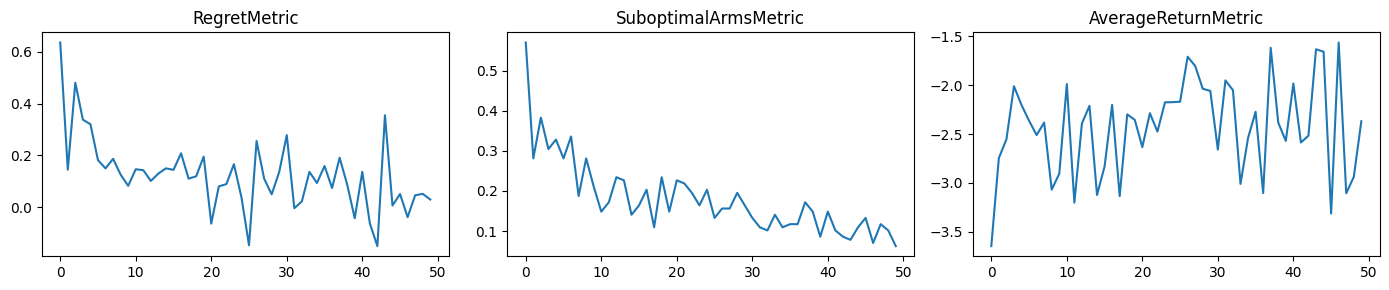

In [95]:
FIG_SIZE = (14,3)
plt.figure(figsize=FIG_SIZE) 

plt.subplot(1, 3, 1)
plt.plot(metric_results['RegretMetric'])
plt.title('RegretMetric')

plt.subplot(1, 3, 2)
plt.plot(metric_results['SuboptimalArmsMetric'])
plt.title('SuboptimalArmsMetric')

plt.subplot(1, 3, 3)
plt.plot(metric_results['AverageReturnMetric'])
plt.title('AverageReturnMetric')

plt.tight_layout()
plt.show()

## Evaluate trained policy with TensorBoard

<img src="imgs/linear_ss_env_train.png" 
     align="center" 
     width="850"
     height="850"/>

In [115]:
from tensorboard import notebook
# notebook.list()

In [111]:
# %load_ext tensorboard
%reload_ext tensorboard

In [116]:
# %tensorboard --logdir=$LOG_DIR

**Finished**